# Operations within GEE

Now that we have learned to reference raster objects in GEE and bring in vector objects (whether via geopandas or directly from a shapefile), we can start finding data that we need that enhance our research. 

In this module, we will conduct four operations:
1. Use `Zonal Statistics` to extract one mean NDVI for a single polygon (one country) from an image
2. Use `Zonal Statistics` to extract one mean NDVI for multiple polygons (three country) from an image
3. Use `Zonal Statistics` to extract several mean NDVI's for multiple polygons (three countries) over multiple images (6 images)
4. Use `Zonal Statistics by Group` to extract the Land Cover type (US) by percentage
5. Use `Zonal Statistics by Group` to extract the Land Cover type (US) by sum
6. Use `Zonal Statistics by Group` to extract the Land Cover type (global) by percentage

For demonstration purposes we will use the geopandas country data in each example (except for NLCD). 

Several visualizations [Mosaic](https://developers.google.com/earth-engine/guides/ic_composite_mosaic) the images together. 

In [1]:
#!pip install geemap

import ee, geemap, pprint, folium
import geopandas as gpd
import pandas as pd
#ee.Authenticate()

def build_map(lat, lon, zoom, vizParams, image, name):
    map = geemap.Map(center = [lat, lon], zoom = zoom)
    map.addLayer(image, vizParams, name)
    return map
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

# Initialize the Earth Engine module.
ee.Initialize()

## Part 1: Single Polygon

Let's start with a single polygon - in the geopandas low-resolution country boundary dataset, we can filter our vector object down to one single country. This uses `pandas` methodology, you can read about slicing dataframes in the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)

<AxesSubplot:>

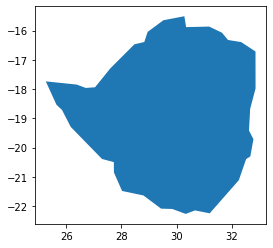

In [30]:
# Country boundaries within geopandas
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
df_single = world.loc[world.name == 'Zimbabwe']
df_single.plot()

In [3]:
# Convert to GEE object
roi = geemap.geopandas_to_ee(df_single)

In [4]:
Map = geemap.Map()
Map.addLayer(roi, {}, "geopandas to ee example")
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [5]:
lat = 8.9; lon = -81.9
zoom = 8
image_collection_name = "LANDSAT/LC08/C01/T1_8DAY_NDVI"
date_start = '2017-01-01'
date_end = '2017-12-31'
name = 'Landsat'

# Mosaic from several images
image = (
    ee.ImageCollection(image_collection_name).mosaic()
)

# Clip the image to the ROI
image = image.clip(roi)

palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']

vizParams = {
    'min': 0, 
    'max': 0.1,
    'palette': palette, 
    'opacity': 0.6
}

map = build_map(lat, lon, zoom, vizParams, image, name)
map

Map(center=[8.9, -81.9], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

Now we need to conduct what is called `zonal statistics` (reduce the data within the polygon). To start look through with the inspector to try to guess what the estimated value would be. Values are all between -1 and 1. For our statistics type, we will use `MEAN` and a scale of 30 match resolution of LandSat. However, this relatively small country took ~10 minutes to complete, so for testing increase the scale to ~500, which will aggregate data together and reduce computational costs. 

In [6]:
output = './data/ndvi_panama.csv'
# geemap.zonal_statistics(image, roi, output, statistics_type='MEAN', scale=1000)

We can use the `pandas` package to inspect our results. 

In [7]:
df = pd.read_csv(output)
df.head()

,mean,system:index,continent,gdp_md_est,iso_a3,name,pop_est
0,0.269739,0,North America,93120,PAN,Panama,3753142


# Exercise 1:

1. Pick a country that's relatively small 
2. Use the geopandas method to obtain a country boundary
3. Convert it to an Earth Engine object 
4. Use the Landsat derived NDVI dataset to calculate the average NDVI for the first 6 months of 2018
5. Use the Zonal Statistics method to calculate the average NDVI

## Part II: Calculate for multiple polygons

Same concept applies to working with mulitple polygons. Zonal statistics will identify that you have three polygons that need to be reduced and break up the data appropriately. For this example, let's choose three countries in the Carribbean (CJamaica, Haiti and Dominican Republic).

<AxesSubplot:>

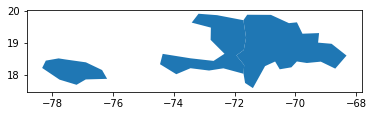

In [8]:
# Country boundaries within geopandas 
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
df_multi = world.loc[world.name.isin(['Jamaica', 'Haiti', 'Dominican Rep.'])]
df_multi.plot()

In [9]:
# Convert to geemap object
# Create a GEE Feature
roi = geemap.geopandas_to_ee(df_multi)

In [10]:
Map1 = geemap.Map()
Map1.addLayer(roi, {}, "geopandas to ee example")
Map1

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [11]:
lat = 19.3; lon = -74.01
zoom = 7
image_collection_name = "LANDSAT/LC08/C01/T1_8DAY_NDVI"
date_start = '2018-01-01'
date_end = '2018-12-31'
name = 'Landsat'

image = (
    ee.ImageCollection(image_collection_name).mosaic()
)

image = image.clip(roi)

palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']

vizParams = {
    'min': 0, 
    'max': 0.1,
    'palette': palette, 
    'opacity': 0.6
}

map1 = build_map(lat, lon, zoom, vizParams, image, name)
map1

Map(center=[19.3, -74.01], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [12]:
# Now we need to conduct zonal statistics 
output = './data/ndvi_carribean.csv'
geemap.zonal_statistics(image, roi, output, statistics_type='MEAN', scale=1000)

In [13]:
df1 = pd.read_csv(output)
df1.head()

,mean,system:index,continent,pop_est,gdp_md_est,name,iso_a3
0,0.428697,0,North America,10646714,19340,Haiti,HTI
1,0.474135,1,North America,10734247,161900,Dominican Rep.,DOM
2,0.400462,2,North America,2990561,25390,Jamaica,JAM


## Part III: Calculate for Multiple Polygons over Multiple Images (Time Series)

This follows the same concept, but because we need to cycle through multiple images, we will not reduce the image collection, as we need to take 'snapshots' of each image. For computational simplicity, let's make a two month window in 2018 and filter the image collection down to this timeframe. We will then use `toBands()` function to create a single image with multiple bands - each band is a date 'snapshot', and we will find the average NDVI within each polygon for each band. 

For this example, we will stick with the same three countries. 

In [14]:
## Extend it by conducint a time series on multiple polygons 

lat = 19.3; lon = -74.01
zoom = 7
image_collection_name = "LANDSAT/LC08/C01/T1_8DAY_NDVI"
date_start = '2018-01-01'
date_end = '2018-02-28'
name = 'Landsat'

image_collection = (
    ee.ImageCollection(image_collection_name)
    .filter(ee.Filter.date(date_start, date_end))
)

# For visualization purposes
image = image_collection.first()
image = image.clip(roi)

palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']

vizParams = {
    'min': 0, 
    'max': 0.1,
    'palette': palette, 
    'opacity': 0.6
}

map2 = build_map(lat, lon, zoom, vizParams, image, name)
map2


Map(center=[19.3, -74.01], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [15]:
# Multi-layered image
ndvi_ts = image_collection.toBands()

In [16]:
output = './data/ndvi_ts_carribean.csv'
geemap.zonal_statistics(ndvi_ts, roi, output, statistics_type='MEAN', scale=1000)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/ozzycampos/Library/CloudStorage/OneDrive-Personal/03_Projects/03_GEE_Labs/03_GEE_DSPG/data/ndvi_ts_carribean.csv


In [17]:
df2 = pd.read_csv(output)
df2.head()

,20180101_NDVI,20180109_NDVI,20180117_NDVI,20180125_NDVI,20180202_NDVI,20180210_NDVI,20180218_NDVI,20180226_NDVI,system:index,continent,pop_est,gdp_md_est,name,iso_a3
0,NaN,0.189607,0.206715,0.334873,0.438416,0.399526,0.369264,0.350981,0,North America,10646714,19340,Haiti,HTI
1,0.199881,0.269277,0.379690,0.273302,0.218979,0.434355,0.353079,0.486218,1,North America,10734247,161900,Dominican Rep.,DOM
2,0.322841,NaN,0.271967,NaN,0.227875,0.582290,0.412892,0.574264,2,North America,2990561,25390,Jamaica,JAM


## Part IV: Zonal Statistics by Group (Percentage)

NDVI is a single metric between -1 and 1. But other datasets have different setups and classifications. For instance, the National Land Cover Dataset is a US dataset that classifies the land cover types - each type receives a certain value. We can't aggregate our data in the same way, because that that value would be meaningless. In cases like this, we can use Zonal Statistics by Group, where group refers to the classification. 
Let's do a quick example breaking up the . 

[Zonal Statistics by Group](https://giswqs.medium.com/calculating-zonal-statistics-by-group-with-earth-engine-a3d4ca794b78)

In [18]:
dataset = ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019')
landcover = ee.Image(dataset.select('landcover'))

Map3 = geemap.Map()
Map3.addLayer(landcover, {}, 'NLCD 2019')

states = ee.FeatureCollection("TIGER/2018/States")
Map3.addLayer(states, {}, 'US States')
Map3.add_legend(builtin_legend='NLCD')

In [19]:
Map3

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [20]:
output = './data/nlcd_stats_pct.csv'

geemap.zonal_statistics_by_group(
    landcover,
    states,
    output,
    statistics_type='PERCENTAGE',
    denominator=1000000,
    decimal_places=2,
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /Users/ozzycampos/Library/CloudStorage/OneDrive-Personal/03_Projects/03_GEE_Labs/03_GEE_DSPG/data/nlcd_stats_pct.csv


In [21]:
df3 = pd.read_csv(output)
df3.head(15)

,Class_81,Class_71,Class_82,Class_95,Class_41,Class_52,Class_31,Class_42,Class_21,Class_43,...,STATEFP,FUNCSTAT,INTPTLAT,DIVISION,REGION,NAME,INTPTLON,MTFCC,ALAND,system:index
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,78,A,18.326748,0,9,United States Virgin Islands,-64.971251,G4000,348021896,00000000000000000022
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,69,A,14.936784,0,9,Commonwealth of the Northern Mariana Islands,145.601021,G4000,472292529,00000000000000000023
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,66,A,13.438289,0,9,Guam,144.772949,G4000,543555840,00000000000000000024
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,60,A,-14.267159,0,9,American Samoa,-170.668267,G4000,197759063,00000000000000000029
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,72,A,18.217648,0,9,Puerto Rico,-66.410799,G4000,8868896030,00000000000000000031
5,0.020511,0.018072,0.004472,0.007629,0.214737,0.003669,0.006424,0.025595,0.026318,0.099201,...,44,A,41.597419,1,1,Rhode Island,-71.527272,G4000,2677779902,00000000000000000005
6,0.029784,0.005342,0.002905,0.004111,0.217609,0.013930,0.002970,0.179917,0.021740,0.370000,...,33,A,43.672691,1,1,New Hampshire,-71.584315,G4000,23189413166,00000000000000000007
7,0.126216,0.001917,0.017520,0.004508,0.383460,0.005779,0.001240,0.125697,0.015595,0.215360,...,50,A,44.068577,1,1,Vermont,-72.669184,G4000,23874175944,00000000000000000009
8,0.032318,0.003817,0.015313,0.005894,0.445076,0.001899,0.001803,0.009749,0.065572,0.092334,...,9,A,41.579864,1,1,Connecticut,-72.746657,G4000,12542497068,0000000000000000000a
9,0.024486,0.013426,0.011628,0.008407,0.140163,0.017577,0.001189,0.196775,0.009500,0.321054,...,23,A,45.409284,1,1,Maine,-68.666616,G4000,79887426037,00000000000000000025


## PART V: Zonal Statistics by Group (Sum)

We can slightly tweak the output and calculate the number of pixels as the output - this is valuable, as we can then look at the resolution of the data and convert the number of pixels to land area. 

In [22]:
output = './data/nlcd_stats_sum.csv'

geemap.zonal_statistics_by_group(
    landcover,
    states,
    output,
    statistics_type='SUM', 
    denominator=1000000,
    decimal_places=2,
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /Users/ozzycampos/Library/CloudStorage/OneDrive-Personal/03_Projects/03_GEE_Labs/03_GEE_DSPG/data/nlcd_stats_sum.csv


In [23]:
df4 = pd.read_csv(output)
df4.head(15)

,Class_81,Class_71,Class_82,Class_95,Class_41,Class_52,Class_31,Class_42,Class_21,Class_43,...,STATEFP,FUNCSTAT,INTPTLAT,DIVISION,REGION,NAME,INTPTLON,MTFCC,ALAND,system:index
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,78,A,18.326748,0,9,United States Virgin Islands,-64.971251,G4000,348021896,00000000000000000022
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,69,A,14.936784,0,9,Commonwealth of the Northern Mariana Islands,145.601021,G4000,472292529,00000000000000000023
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,66,A,13.438289,0,9,Guam,144.772949,G4000,543555840,00000000000000000024
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,60,A,-14.267159,0,9,American Samoa,-170.668267,G4000,197759063,00000000000000000029
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,72,A,18.217648,0,9,Puerto Rico,-66.410799,G4000,8868896030,00000000000000000031
5,82.06,72.30,17.89,30.52,859.11,14.68,25.70,102.40,105.29,396.88,...,44,A,41.597419,1,1,Rhode Island,-71.527272,G4000,2677779902,00000000000000000005
6,721.24,129.35,70.35,99.54,5269.52,337.31,71.91,4356.77,526.44,8959.73,...,33,A,43.672691,1,1,New Hampshire,-71.584315,G4000,23189413166,00000000000000000007
7,3143.22,47.73,436.31,112.26,9549.47,143.92,30.89,3130.28,388.37,5363.20,...,50,A,44.068577,1,1,Vermont,-72.669184,G4000,23874175944,00000000000000000009
8,464.02,54.80,219.86,84.62,6390.41,27.27,25.89,139.98,941.48,1325.73,...,9,A,41.579864,1,1,Connecticut,-72.746657,G4000,12542497068,0000000000000000000a
9,2243.57,1230.16,1065.44,770.27,12842.87,1610.55,108.94,18030.04,870.49,29417.45,...,23,A,45.409284,1,1,Maine,-68.666616,G4000,79887426037,00000000000000000025


## PART V: Zonal Statistics by Group for Global Data (Sum)

NLCD is a Continental-US only product, but there are many different global datasets that we can use. Let's go through the same process with the MODIS Global Land Cover dataset, which is an excellent starting point. 

In [24]:
landcover = ee.Image('MODIS/006/MCD12Q1/2013_01_01').select('LC_Type1')

vis = {
    'min': 1.0,
    'max': 17.0,
    'palette': [
        '05450a',
        '086a10',
        '54a708',
        '78d203',
        '009900',
        'c6b044',
        'dcd159',
        'dade48',
        'fbff13',
        'b6ff05',
        '27ff87',
        'c24f44',
        'a5a5a5',
        'ff6d4c',
        '69fff8',
        'f9ffa4',
        '1c0dff',
    ],
}

Map4 = geemap.Map()
Map4.setCenter(6.746, 46.529, 2)
Map4.addLayer(landcover, vis, 'MODIS Land Cover')

In [25]:
Map4.add_legend(builtin_legend='MODIS/006/MCD12Q1')

In [26]:
countries = geemap.geopandas_to_ee(world)
Map4.addLayer(countries, {}, 'Countries')

In [27]:
Map4

Map(center=[46.529, 6.746], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

In [28]:
output = './data/lancover_world.csv'

geemap.zonal_statistics_by_group(
    landcover,
    countries,
    output,
    statistics_type='PERCENTAGE',
    denominator=1000000,
    decimal_places=2,
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /Users/ozzycampos/Library/CloudStorage/OneDrive-Personal/03_Projects/03_GEE_Labs/03_GEE_DSPG/data/lancover_world.csv


In [29]:
df5 = pd.read_csv(output)
df5.head(15)

,Class_10,Class_11,Class_sum,Class_8,Class_12,Class_7,Class_13,Class_14,Class_9,Class_15,...,Class_4,Class_3,Class_6,Class_5,system:index,continent,pop_est,gdp_md_est,name,iso_a3
0,0.070048,0.002326,19363.57,0.013813,0.020892,0.000000,0.000000,0.004198,0.042590,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,Oceania,920938,8374.0,Fiji,FJI
1,0.412735,0.002272,932754.67,0.018651,0.015259,0.000433,0.000649,0.002421,0.409712,0.000000,...,0.025609,0.000000,0.000388,0.026398,1,Africa,53950935,150600.0,Tanzania,TZA
2,0.000198,0.000000,96682.45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2,Africa,603253,906.5,W. Sahara,ESH
3,0.192529,0.023816,10037104.97,0.186752,0.050757,0.092624,0.000929,0.000758,0.153024,0.022625,...,0.010082,0.000109,0.000008,0.069945,3,North America,35623680,1674000.0,Canada,CAN
4,0.307701,0.004180,9510132.69,0.145979,0.149357,0.100189,0.013015,0.007466,0.075932,0.007844,...,0.070421,0.000000,0.001268,0.020967,4,North America,326625791,18560000.0,United States of America,USA
5,0.858267,0.001732,2729275.51,0.002282,0.047921,0.001794,0.000796,0.000000,0.001943,0.001952,...,0.000114,0.000005,0.000096,0.003106,5,Asia,18556698,460700.0,Kazakhstan,KAZ
6,0.418772,0.000855,461265.45,0.000000,0.109482,0.043518,0.016042,0.000000,0.000176,0.004402,...,0.000000,0.000000,0.000000,0.000000,6,Asia,29748859,202300.0,Uzbekistan,UZB
7,0.008221,0.014476,464487.50,0.056381,0.000411,0.000000,0.000317,0.001927,0.033257,0.000000,...,0.000000,0.000000,0.000000,0.000000,7,Oceania,6909701,28020.0,Papua New Guinea,PNG
8,0.010842,0.019413,1819096.77,0.190502,0.020905,0.000000,0.005454,0.042234,0.043878,0.000000,...,0.000927,0.000000,0.000035,0.000012,8,Asia,260580739,3028000.0,Indonesia,IDN
9,0.314427,0.007742,2784339.87,0.031375,0.126582,0.237683,0.004117,0.000568,0.146241,0.000633,...,0.021184,0.000000,0.000342,0.004110,9,South America,44293293,879400.0,Argentina,ARG


## Exercise - Canadian Crop Inventory
Extract the overall (don't aggregate over time) percentage classification for the [Canada AAFC Annual Crop Inventory](https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI).
1. Extract the Canadian border from geopandas low-resolution and convert to GEE object
2. Read in the image collection
3. Reduce the image collection into a single image
4. Zonal Statistics by group

<AxesSubplot:>

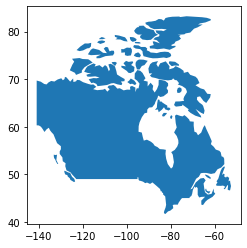

In [52]:
# Country boundaries within geopandas
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
df_canada = world.loc[world.name == 'Canada']
df_canada.plot()

In [53]:
# Convert to GEE object
roi2 = geemap.geopandas_to_ee(df_single)

In [55]:
# Reduce down to an image
# select the first image from the landcover band 
landcover_canada = ee.ImageCollection('AAFC/ACI').select('landcover').first()

In [57]:
output = './data/lancover_canada.csv'

geemap.zonal_statistics_by_group(
    landcover,
    roi2,
    output,
    statistics_type='PERCENTAGE',
    denominator=1000000,
    decimal_places=2,
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /Users/ozzycampos/Library/CloudStorage/OneDrive-Personal/03_Projects/03_GEE_Labs/03_GEE_DSPG/data/lancover_canada.csv
